## Variación espacio-temporal precipitación total

**PROYECTO:** SISTEMA PARA EL SEGUIMIENTO DE ECOSISTEMAS VENEZOLANOS \
**AUTOR:** Javier Martinez

Directorio

In [1]:
import os

print('> Directorio actual: ', os.getcwd())  
os.chdir('../')
print('> Directorio actual: ', os.getcwd()) 

> Directorio actual:  /media/javier/Compartida/doctorado/ssev-analytics/cerro_saroche
> Directorio actual:  /media/javier/Compartida/doctorado/ssev-analytics


In [2]:
from utils.MONGO import CONEXION
from utils.UTILS import *
from datetime import datetime
import pandas as pd

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

Datos de precipitación 

In [4]:
park = 'cerro_saroche'

In [5]:
pd_precipitacion = pd.read_pickle(f'./{park}/data/narx_precipitacion.pkl')
pd_precipitacion.head()

,park,periodo,year,month,id_point,latitud,longitud,type,precipitacion_mm,elevacion_media
0,cerro_saroche,1970-01-01,1970,1,1,10.31,-69.83,historical,0.913065,508.541046
1,cerro_saroche,1970-01-01,1970,1,2,10.31,-69.73,historical,0.958915,625.942932
2,cerro_saroche,1970-01-01,1970,1,3,10.31,-69.63,historical,1.026073,731.954834
3,cerro_saroche,1970-01-01,1970,1,4,10.31,-69.53,historical,1.095035,761.129150
4,cerro_saroche,1970-01-01,1970,1,5,10.31,-69.43,historical,1.203287,726.967285


In [6]:
pd_historical = pd_precipitacion.query("type=='historical'")
pd_historical.head()

,park,periodo,year,month,id_point,latitud,longitud,type,precipitacion_mm,elevacion_media
0,cerro_saroche,1970-01-01,1970,1,1,10.31,-69.83,historical,0.913065,508.541046
1,cerro_saroche,1970-01-01,1970,1,2,10.31,-69.73,historical,0.958915,625.942932
2,cerro_saroche,1970-01-01,1970,1,3,10.31,-69.63,historical,1.026073,731.954834
3,cerro_saroche,1970-01-01,1970,1,4,10.31,-69.53,historical,1.095035,761.129150
4,cerro_saroche,1970-01-01,1970,1,5,10.31,-69.43,historical,1.203287,726.967285


<AxesSubplot:>

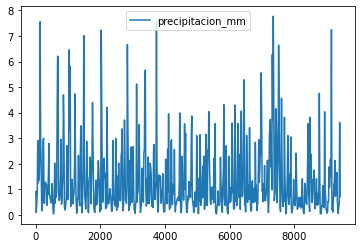

In [7]:
pd_historical.query(f"id_point=={1}")[['precipitacion_mm',
#'prediction_precipitacion_mm'
]].plot()

Preparando los datos

In [8]:
trans_variable = MinMaxScaler()

variables = ['year',	'month',	'latitud',	'longitud', 'elevacion_media']


trans_variable.fit(pd_historical[variables])

data_model = pd_historical[variables].copy()

data_model[variables] = trans_variable.transform(pd_historical[variables])

data_model.head()

,year,month,latitud,longitud,elevacion_media
0,0.0,0.0,1.0,0.00,0.000000
1,0.0,0.0,1.0,0.25,0.285972
2,0.0,0.0,1.0,0.50,0.544201
3,0.0,0.0,1.0,0.75,0.615265
4,0.0,0.0,1.0,1.00,0.532052


In [9]:
# Transformacion
transformacion = LogMinimax.create( pd_historical.precipitacion_mm.to_numpy() )

data_model['precipitacion_mm'] = transformacion.transformacion()

data_model.head()

,year,month,latitud,longitud,elevacion_media,precipitacion_mm
0,0.0,0.0,1.0,0.00,0.000000,0.623173
1,0.0,0.0,1.0,0.25,0.285972,0.631117
2,0.0,0.0,1.0,0.50,0.544201,0.642091
3,0.0,0.0,1.0,0.75,0.615265,0.652637
4,0.0,0.0,1.0,1.00,0.532052,0.667921


## Red ANN

Data entrenamiento y validación

https://www.section.io/engineering-education/build-ann-with-keras/

In [10]:
data_model.shape

(9435, 6)

In [11]:
test_size = 0.2
random_state = 0
X_train, X_test, y_train, y_test = train_test_split(data_model[variables].to_numpy(), 
                                                    data_model['precipitacion_mm'].to_numpy(), 
                                                    test_size = test_size, random_state = random_state)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(7548, 5)
(7548,)
(1887, 5)
(1887,)


Generando la red

In [12]:
activation = ['sigmoid','sigmoid','sigmoid']

total = X_train.shape[1]

n_neuronas = [total, int(2*total/3), 1 ]
epochs = 500
patience = 10

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [14]:
# Metrícas
mae = keras.metrics.MeanAbsoluteError()
rmse = keras.metrics.RootMeanSquaredError()

# ANN
model = keras.models.Sequential()

model.add(keras.layers.Dense(units=n_neuronas[0], activation=activation[0], input_shape=X_train[0].shape))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(units=n_neuronas[1], activation=activation[1]))

model.add(keras.layers.Dense(units=n_neuronas[2], activation=activation[2]))

# Compilando modelo
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mae,rmse]) 

# Parada temprana
callback = keras.callbacks.EarlyStopping(
                                            monitor="loss",
                                            min_delta=0,
                                            patience=patience,
                                            verbose=0,
                                            mode="min",
                                            baseline=None,
                                            restore_best_weights=False,
                                        )

Entrenamiento

In [15]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=1,
                    verbose=0,
                    workers=2,
                    callbacks=[callback])

print(f'Total epocas:{len(history.epoch)}')

Total epocas:85


Validación

In [16]:
# make predictions
trainPredict = model.predict(X_train, verbose=0).reshape(-1)
testPredict = model.predict(X_test, verbose=0).reshape(-1)

In [17]:
def time_dormat(year = 2003, month = 1):

    if month < 10:
        month = '0'+str(int(month))
    else:
        month = str(int(month))

    return str(int(year))+'-'+month+'-'+'01'

time_dormat()

'2003-01-01'

In [25]:
# Training
trainind_pd = pd.DataFrame(y_train,
                            index = list(range(y_train.shape[0])) ,
                            columns=['precipitacion_mm']
                            )

trainind_pd[variables] = X_train
trainind_pd['prediction_precipitacion_mm'] = trainPredict

trainind_pd[variables] = trans_variable.inverse_transform(trainind_pd[variables])
trainind_pd['precipitacion_mm'] = trainind_pd['precipitacion_mm'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
trainind_pd['prediction_precipitacion_mm'] = trainind_pd['prediction_precipitacion_mm'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )

trainind_pd[['year','month']] = trainind_pd[['year','month']].astype(int)

trainind_pd['periodo'] = trainind_pd[['year','month']].apply(lambda x: time_dormat(year = x.year, month = x.month),1)
trainind_pd['periodo'] = pd.to_datetime(trainind_pd['periodo'] )

trainind_pd['type'] = 'training'

trainind_pd.head()

,precipitacion_mm,year,month,latitud,longitud,elevacion_media,prediction_precipitacion_mm,periodo,type
0,3.896306,2013,5,10.11,-69.73,680.322571,1.072637,2013-05-01,training
1,0.493590,1973,7,10.11,-69.83,553.383484,1.121805,1973-07-01,training
2,1.920176,2004,4,10.11,-69.53,757.867737,1.302706,2004-04-01,training
3,1.561436,1988,5,10.31,-69.83,508.541046,1.175081,1988-05-01,training
4,1.134663,2017,9,10.31,-69.43,726.967285,1.347285,2017-09-01,training


In [26]:
# Validacion entrenamiento
training_metrics = metrics(observado=trainind_pd.precipitacion_mm,
                           prediccion=trainind_pd.prediction_precipitacion_mm)

training_metrics

{'mape': 78.76801524087202,
 'mae': 0.789536021008174,
 'mse': 1.2517377920455464,
 'rmse': 1.5668475000350595,
 'r2': 0.0539634254541016}

In [27]:
# Test
test_pd = pd.DataFrame(y_test,
                        index = list(range(y_test.shape[0])) ,
                        columns=['precipitacion_mm']
                        )

test_pd[variables] = X_test
test_pd['prediction_precipitacion_mm'] = testPredict

test_pd[variables] = trans_variable.inverse_transform(test_pd[variables])
test_pd['precipitacion_mm'] = test_pd['precipitacion_mm'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )
test_pd['prediction_precipitacion_mm'] = test_pd['prediction_precipitacion_mm'].apply(lambda x: transformacion.inversa(x) if np.isnan(x)==False else np.nan )

test_pd[['year','month']] = test_pd[['year','month']].astype(int)
test_pd['periodo'] = test_pd[['year','month']].apply(lambda x: time_dormat(year = x.year, month = x.month),1)
test_pd['periodo'] = pd.to_datetime(test_pd['periodo'] )

test_pd['type'] = 'test'


test_pd.head()

,precipitacion_mm,year,month,latitud,longitud,elevacion_media,prediction_precipitacion_mm,periodo,type
0,4.374323,2011,11,10.11,-69.83,553.383484,1.032203,2011-11-01,test
1,0.648070,2006,9,10.21,-69.53,769.925049,1.310856,2006-09-01,test
2,1.092988,1993,9,10.11,-69.73,680.322571,1.123945,1993-09-01,test
3,2.263130,1986,10,10.31,-69.43,726.967285,1.412738,1986-10-01,test
4,3.725404,1978,10,10.11,-69.43,712.881348,1.494002,1978-10-01,test


In [28]:
# Validacion entrenamiento
test_metrics = metrics(observado=test_pd.precipitacion_mm,
                       prediccion=test_pd.prediction_precipitacion_mm)

test_metrics

{'mape': 85.60724942818779,
 'mae': 0.8206817373751318,
 'mse': 1.3166431862286536,
 'rmse': 1.7335492798423409,
 'r2': 0.029280351232291557}

In [33]:
pd_trainig_test = pd.concat([trainind_pd,test_pd])
pd_trainig_test

,precipitacion_mm,year,month,latitud,longitud,elevacion_media,prediction_precipitacion_mm,periodo,type
0,3.896306,2013,5,10.11,-69.73,680.322571,1.072637,2013-05-01,training
1,0.493590,1973,7,10.11,-69.83,553.383484,1.121805,1973-07-01,training
2,1.920176,2004,4,10.11,-69.53,757.867737,1.302706,2004-04-01,training
3,1.561436,1988,5,10.31,-69.83,508.541046,1.175081,1988-05-01,training
4,1.134663,2017,9,10.31,-69.43,726.967285,1.347285,2017-09-01,training
...,...,...,...,...,...,...,...,...,...
1882,1.414814,2021,5,10.21,-69.73,652.016235,1.089513,2021-05-01,test
1883,1.041618,1978,2,10.31,-69.83,508.541046,0.246712,1978-02-01,test
1884,0.822986,2017,5,10.21,-69.63,850.282715,1.177460,2017-05-01,test
1885,1.191266,1978,11,10.21,-69.63,850.282715,1.284244,1978-11-01,test


In [36]:
pd_trainig_test[(pd_trainig_test.year==1970) & (pd_trainig_test.latitud==10.31) & (pd_trainig_test.longitud==-69.83)]

,precipitacion_mm,year,month,latitud,longitud,elevacion_media,prediction_precipitacion_mm,periodo,type
146,1.394330,1970,7,10.31,-69.83,508.541046,1.236049,1970-07-01,training
489,0.546783,1970,2,10.31,-69.83,508.541046,0.585430,1970-02-01,training
983,0.369283,1970,11,10.31,-69.83,508.541046,1.207873,1970-11-01,training
1162,2.993050,1970,5,10.31,-69.83,508.541046,1.224692,1970-05-01,training
1527,2.861612,1970,4,10.31,-69.83,508.541046,1.127808,1970-04-01,training
1997,0.153676,1970,2,10.31,-69.83,508.541046,0.258223,1970-02-01,training
2258,0.413783,1970,2,10.31,-69.83,508.541046,0.585384,1970-02-01,training
2946,1.105199,1970,8,10.31,-69.83,508.541046,1.227772,1970-08-01,training
3092,0.895653,1970,4,10.31,-69.83,508.541046,1.129861,1970-04-01,training
3138,7.556980,1970,10,10.31,-69.83,508.541046,1.220863,1970-10-01,training


In [30]:
for_join = pd_historical\
                .groupby(['latitud',	'longitud', 'id_point'],as_index=False)\
                .count()[['latitud',	'longitud', 'id_point']]


pd_final = pd.merge(pd_trainig_test,for_join,on=['latitud',	'longitud'],how = 'left').sort_values(['periodo','id_point'])
pd_final.head()

,precipitacion_mm,year,month,latitud,longitud,elevacion_media,prediction_precipitacion_mm,periodo,type,id_point
3296,0.472320,1970,1,10.31,-69.83,508.541046,0.223746,1970-01-01,training,1
6973,0.913065,1970,1,10.31,-69.83,508.541046,0.225098,1970-01-01,training,1
1900,0.958915,1970,1,10.31,-69.73,625.942932,0.266257,1970-01-01,training,2
9282,0.517999,1970,1,10.31,-69.73,625.942932,0.264523,1970-01-01,test,2
3767,0.591881,1970,1,10.31,-69.63,731.954834,0.321848,1970-01-01,training,3


<AxesSubplot:xlabel='periodo'>

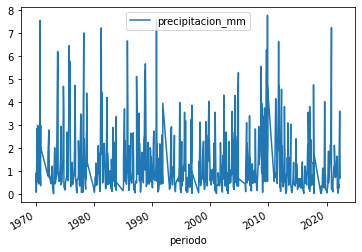

In [31]:
pd_plot = pd_final.sort_values('periodo').query(f"id_point=={1}")
pd_plot = pd_plot.set_index('periodo')

pd_plot[['precipitacion_mm',
#'prediction_precipitacion_mm'
]].plot()